Chargement du fichier "train.tsv.zip" ou Tweets-Flight :

In [ ]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1B88v1WKDWdxqvRzRNfUpszhcLeUSDQbd"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train.tsv.zip')

downloaded = drive.CreateFile({'id':"1V96pme-eFHBOerhM79tNhRtwoh2VNkDD"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Tweets-Flight.csv')

Les Import dont on a besoin :

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import shuffle
def shuffle_list(*ls):
  l =list(zip(*ls))
  shuffle(l)
  return zip(*l)

%matplotlib inline

# DL les datas :

MovieReviews :

In [ ]:
data=pd.read_csv("train.tsv.zip", sep="\t")
# Display 5 random samples
data.sample(5)

In [ ]:


#X = data['Phrase']
#y = data["Sentiment"]



rev0=data['Phrase']
sentiment0=data["Sentiment"]
#y=to_categorical(movie_reviews.Sentiment.values)
print("Nombre total de Reviews :"+ str(len(sentiment0)))

rev,sentiment=shuffle_list(rev0,sentiment0)

# On re-equilible la base de données : on doit remove 35000 'neutral'
n=79582-35000
k=0
y0=[]
reviews0=[]
for i in range(len(sentiment)):
  el=sentiment[i]
  if el==0 : 
    y0.append(0)
    reviews0.append(rev[i])
  if el==1 :
    y0.append(1)
    reviews0.append(rev[i])
  if el==2 and k<n:
    k+=1 
    y0.append(2)
    reviews0.append(rev[i])
  if el==3 :
    y0.append(3)
    reviews0.append(rev[i])
  if el==4 :
    y0.append(4)
    reviews0.append(rev[i])

y=np.array(y0,dtype='float32')
X=np.array(reviews0)
print("Nombre total de Reviews apres equilibrage :"+ str(len(y)))

print(X)
print(y)



Nombre total de Reviews :156060
Nombre total de Reviews apres equilibrage :121060
['gentle film' "'s a dark , gritty story" '-LRB- as best I remember -RRB-'
 ... 'never reach satisfying conclusions'
 'the discomfort and embarrassment'
 'This painfully unfunny farce traffics in tired stereotypes and encumbers itself with complications ... that have no bearing on the story .']
[3. 3. 2. ... 1. 1. 0.]


OU

Tweets-Flights :

In [ ]:
tweet_reviews = pd.read_csv('Tweets-Flight.csv')
rev=np.array(tweet_reviews['text'])
sentiment=tweet_reviews['airline_sentiment']
y0=[]
reviews0=[]

# On re-equilible la base de données : on doit remove 5500 'neutral'
n=9178-5500
k=0

for i in range(len(sentiment)):
  el=sentiment[i]
  if el=='negative' and k<n:
    k+=1 
    y0.append(0)
    reviews0.append(rev[i])

  if el=='neutral': 
    y0.append(1)
    reviews0.append(rev[i])

  if el=='positive': 
    y0.append(2)
    reviews0.append(rev[i])

y=np.array(y0,dtype='float32')
X=np.array(reviews0)

print("Nombre total de Tweets :"+ str(len(X)))

Nombre total de Tweets :9140


In [ ]:
print(X)
print(y)

['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 ... '@AmericanAir thank you we got on a different flight to Chicago.'
 '@AmericanAir Please bring American Airlines to #BlackBerry10'
 '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?']
[1. 2. 1. ... 2. 1. 1.]


Separation des datas en train et validation :

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

Utilisation du GPU :

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


Remove les stop-words :

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Convertion des datas en utilisant TF-IDF :

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)


In [ ]:
X_train

array(['Report', 'innovative backgrounds', 'laughed throughout the movie',
       ..., 'sometimes improbable story',
       'can be when put in service of of others', 'in the pants'],
      dtype='<U283')

In [ ]:
X_train_preprocessed

array(['report', 'innovative backgrounds', 'laughed throughout movie',
       ..., 'sometimes improbable story', 'can put service others',
       'pants'], dtype='<U216')

Recuperation du score :

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get  scores
    score = cross_val_score(
        model, X_train_tfidf, y_train, cv=kf)

    return score.mean()

Best alpha:  0.3


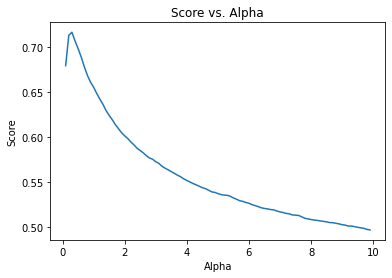

In [ ]:
from sklearn.naive_bayes import MultinomialNB
get_auc_CV(MultinomialNB(0.4))
res = pd.Series([get_auc_CV(MultinomialNB(i))for i in np.arange(0.1, 10, 0.1)],index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('Score vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.show()

Evaluation du Naive Bayes sur les datas :

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(probs, y_true):
    y_pred = np.transpose(np.argmax(probs,1))
    return  accuracy_score(y_true, y_pred)
    

TEST 3 CLASSES : (UNIQUEMENT pour MovieReviews. N'executer la cellule suivante que si vous voulez reduire de 5 classes à 3 classes)

In [ ]:
y_train

array([1., 0., 2., ..., 0., 1., 1.], dtype=float32)

In [ ]:
##############
temp_train=[]
for el in y_train :
  if el<= 1 :
    temp_train.append(0)
  elif el == 2 :
    temp_train.append(1)
  else :
    temp_train.append(2)
y_train=np.array(temp_train,dtype='int')

temp_val=[]
for el in y_val :
  if el<= 1 :
    temp_val.append(0)
  elif el == 2 :
    temp_val.append(1)
  else :
    temp_val.append(2)
y_val=np.array(temp_val,dtype='int')
num_classes=3
##############

In [ ]:
y_train

array([1, 2, 2, ..., 0, 1, 2])

Fin Test 3 classes

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate(probs,y_val)

0.7100656455142232

In [ ]:
Y_sortie=probs.argmax(1)
Y_val=np.array(y_val,dtype=int)
print(Y_sortie)
print(Y_val)

In [ ]:
num_classes= 5
reussite=[0 for i in range(num_classes)]
for i in range(len(y_val)):
  reussite[Y_val[i]]+=(Y_sortie[i]==Y_val[i])

print("Nombre de reussite : " + str(sum(reussite))+" / "+str(len(Y_val)) )
print(reussite)
taux_reussite=[reussite[i]/sum(Y_val==i) for i in range(num_classes)]
print(taux_reussite)

Nombre de reussite : 649 / 914
[356, 169, 124, 0, 0]
[0.9222797927461139, 0.5614617940199336, 0.5462555066079295, nan, nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
